# Projekt MSP1
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 22. 10. 2023 v IS VUT. Kontrola bude probíhat na Pythonu 3.10.12; neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

_Jakub Kuzník xkuzni04_

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi. Není dovoleno načítat jiné knihovny.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Z logu vás budou nejvíce zajímat řádky
```
Configuration: config6
Run: 191
Time of run: 53.298725254089774
```

Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou je to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

In [131]:
def load_logfile(f) -> dict:
    """Load a logfile from a file-like object and return a dict with the data."""
    data = {
        "conf": None,
        "run": None,
        "time": np.nan
    }

    for line in f:
        line = line.decode("utf-8")

        # In loaded line it will get rid of spaces 
        # and line ends symbols 
        line = line.replace(" ", "")
        line = line.replace("\n", "")
        
        # Split string before and after delimeter into two 
        split_string = line.split(":")

        # Match first string and store the second one into dict.
        # !! We are even storying not SUCCESS status.
        if split_string[0] == "Configuration":
            data["conf"] = split_string[1]
        elif split_string[0] == "Run":
            data["run"] = split_string[1]
        elif split_string[0] == "Timeofrun":
            data["time"] = float(split_string[1])
        
    return data

data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        with zf.open(filename, "r") as f:
            data.append(load_logfile(f))
            
df = pd.DataFrame(data)
df


,conf,run,time
0,config1,0,104.967142
1,config1,1,98.617357
2,config1,2,106.476885
3,config1,3,115.230299
4,config1,4,97.658466
...,...,...,...
1195,config6,195,168.809495
1196,config6,196,159.607244
1197,config6,197,171.049799
1198,config6,198,164.478283


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. 

[Text(0.5, 0, 'Configuration'), Text(0, 0.5, 'Time')]

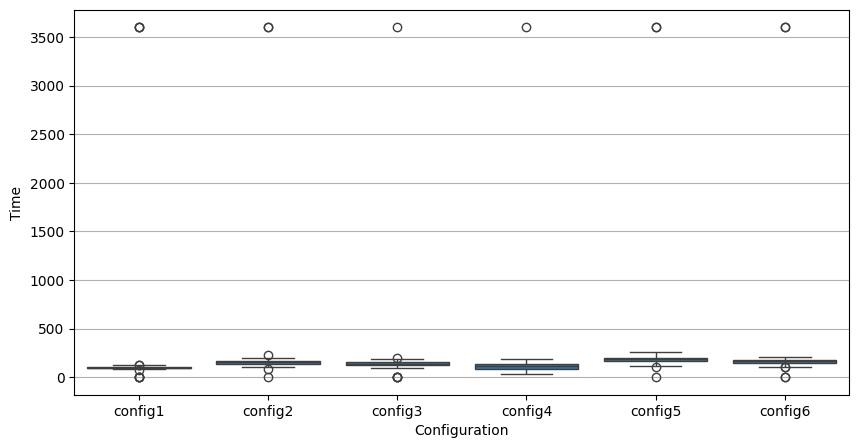

In [132]:
df = pd.DataFrame(data)

# We are using subplots for easier work with x,y labels 
fig, ax = plt.subplots(figsize=(10,5))
plt.grid(True)

# For each configuration -> 
#   do boxplot 
sns.boxplot(x='conf', y='time', data=df)

# Set axis labels 
ax.set(xlabel="Configuration", ylabel="Time")



__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů?_


  Boxplot nám ukazuje očekávané minimum (max(min(X), Q1 – 1.5 * (Q3-Q1))) a očekávané maximum (analogicky k minimu) pro jednotlivé konfigurace. Vidíme, že na grafu existují hodnoty, které nespadají do těchto očekávaných rozsahů. Tyto hodnoty jsou zobrazeny jako kroužky.

Odchylky, blížící se k času 0: 
  Na první pohled se tyto odchylky nemusí jevit jako vážný problém, ale je třeba mít na paměti, že čas nemůže být záporný. Pokud se čas blíží k nule, může to naznačovat, že se proces vlastně nepodařilo spustit.

Odchylky, blížící se k času 3600:
  Tyto odchylky jsou velmi výrazné. Vzhledem k tomu, že všechny tyto odchylky mají stejnou výšku, můžeme předpokládat, že jde o nějaký maximální časový limit, po němž je proces ukončen.



Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

[Text(0.5, 0, 'Configuration'), Text(0, 0.5, 'Time')]

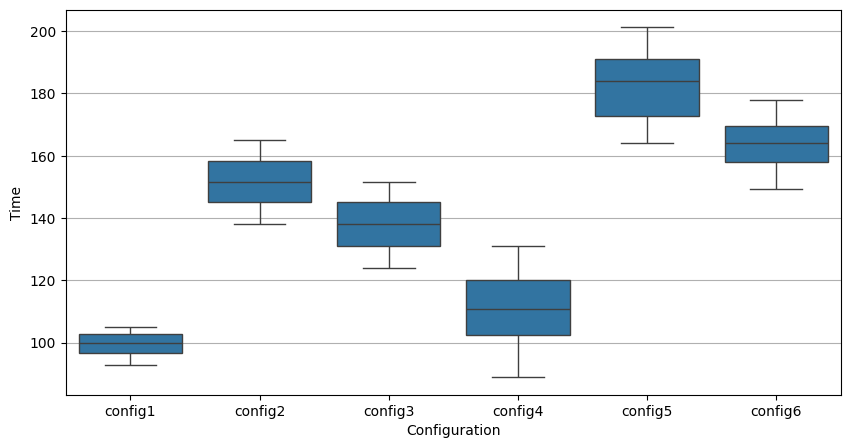

In [136]:
df = pd.DataFrame(data)

# Group graphs by config name 
grouped = df.groupby('conf')

# Calculate the upper and bottom (quantile) for each group
q_down = grouped['time'].transform('quantile', 0.25)
q_up = grouped['time'].transform('quantile', 0.75)

# Create a boolean mask for rows to be removed
mask_upper = df['time'] < q_up
mask_bottom = df['time'] > q_down
# combine masks 
mask_combined = mask_upper & mask_bottom

# Apply the mask to filter out rows
df = df[mask_combined]

# We are using subplots for easier work with x,y labels 
fig, ax = plt.subplots(figsize=(10,5))
plt.grid(True)

# For each configuration -> 
#   do boxplot 
sns.boxplot(x='conf', y='time', data=df)

# Set axis labels 
ax.set(xlabel="Configuration", ylabel="Time")

## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry času pro jednotlivé konfigurace.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [ ]:
# TODO deskriptivni parametry

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte, co všechno můžeme z parametrů vyčíst._

## Vizualizace
Vizualizujte časy běhů algoritmů v jednom kompaktním grafu tak, aby byl zřejmý i rozptyl hodnot. Zvolte vhodný graf, který pak níže komentujte.

In [ ]:
# TODO graf

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte  výsledky z tabulky._

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. Můžete i přidat další buňky.

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet studentova rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

In [ ]:
# TODO: Implementace s vyuzitim knihovni funkce

__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_

In [ ]:
# TODO vlastni implementace zvoleneho testu